# Speech Recognition using Graphs

Team members: Adrian Löwenstein, Kiran Bacsa, Manuel Vonlanthen<br>
Date:         22.01.2018

## Problem Description

In this section we will describe in detail the problem we studied during the final project of the course "Network Tour of Data Science". We wanted to do speech recognition using the Graph/Network theory learned during the course. We were inspired by the kaggle competition "Tensor Flow Speech Recognition Challenge: Can you build an algorithm that understands simple speech commands" put up by google. In said competition the goal was to classify 20 distinct words. Words that do not belong to any of the 20 classes should be classified as "unknown". For the kaggle competition the TensorFlow library had to be used. For this purpose Google provided a large training data set (64'720 audio files) with known labels and an even larger test (150'000+ audio files) with unknown labels for them to evaluate the built algorithms. We, however, decided to only work with the provided training data, because the data set is large enough to perform statistically valid model evaluation and it this we we weren't dependant on the kaggle competition.<br>
<br>
The provided data set consists of 64'720 .wave files of length 1s, sampled with a sampling rate of $16$ kHz. Each audio files contain one of 30 possible spoken words. The files were created using crowd-sourcing, which means that the conditioning of the audio signal is not equal for all audio files. This led to very different noise levels, amplitudes, etc. Also the same speaker might have recorded different audio files. The 20 core words which have to be classified correctly are:

    - up, down
    - zero, one, two, three, four, five ,six ,seven, eight, nine
    - go, stop 
    - left, rigth
    - no, yes
    - off, on
In addition to these 20 words, 10 other words were provided inside the training set to train the algorithm to classify words which it should not react to as "unknown". The following "unknown" words are contained in the training data:

    - bed
    - bird, cat, dog, mouse
    - tree
    - happy
    - marvin, sheila
    - wow
<br>
At this point we want to empphasize that we did not study the problem suggested for the kaggle competition, but a slightly simplified one. First of all we did not restrict ourselves to using TensorFlow, in fact we did not use it at all. However, we did restrict ourselves to use Graph theory as central part of our classification algorithm. Our goal was, using only the provided training set, to build a classifier which calssifies the above listed core words as accurate as possible. In addition, all other words (the 10 additional words) should be classified as "unknown". This means we wanted to build a "word"-classifier for 21 different classes using graph theory.<br>
<br>
Mathematically, we can define the task as follows. We split up our training data set into a training set $S_t$ of some size N (we will later comment on its size) and a validation set $S_v$ of size $V = 64'720-N$, used to check how well the classifier works.
Using $\mathbf{x_n} \in S_t$, which is some training audio file $\mathbf{x_n} \in \mathbb{R}^D$, where $D = 1s\cdot 16kHz = 16000$ is the number of samples per audio file, we can build our training data matrix $\mathbf{X}^{\mathbf{N\times D}}$. Using $\mathbf{X}$ we want to learn a function $f(\mathbf{v_v}, \mathbf{X}): \mathbb{R}^{N+1\times D} \to \{1,2,3,...,21\}$, where $\mathbf{v_v}\in S_v$ is a validation audio file $\mathbf{v_v}\in\mathbb{R}^D$, such that the resulting estimated label $\hat{y_v} = f(\mathbf{v_V}, \mathbf{X})$ is equal to the correct label $y_v \in \{1,2,3,...,21\}$ for as many validation samples as possible. Hence we use the accuracy measure defined as
$$acc = \frac{\sum_{i=1}^{K}\max[\min[(|y_k-\hat{y_k}|),1],0]}{K},$$
where $K$ is the number of tested samples $v_k$. We want to remark that the model could also work with a subset $\mathbb{v}\subseteq S_v$, also called batch, instead of a single validation file $v_v$. In this case we define the cardinality of said subset $|\mathbb{v}|=K$ and the model would correspond to $f(\mathbb{v}, \mathbf{X}): \mathbb{R}^{(N+K)\times D} \to \{1,2,3,...,21\}^K$.

## Imports

In [11]:
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd
from tqdm import tqdm

# Math
import numpy as np
import scipy.stats
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa
import librosa.display
from scipy import sparse, stats, spatial
import scipy.sparse.linalg

# Machine learning
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.utils import shuffle
from sklearn.metrics import  confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import pandas as pd

# Benchmarking
import time

# Cutting 

from cut_audio import *

%matplotlib inline

## Recompute

**WARNING** If you set recompute to True this will reextract all featrues and re-classify all audio file, which will take several days, so do not do it. It is here for completeness so you can see how the steps were done during th project. We've already computed these steps and saved the results into pickle files. Our entire used data, as well as the pickle files can be found on "Link".

In [12]:
recompute = False

## Feature Extraction (Adrian)

Describe the data set....<br>
Describe the entire pipeline from audio file to feature vector for one audio dile...<br>
Shortly mentione other Features that were tried...<br>
Set up python function in which the features of the entire training set could be extracted and put it into a if recompute is true... <br>
Load the pickle with all features in them,...

In [13]:
# Load features
features_og = pd.read_pickle('./Features Data/cut_mfccs_all_raw_10_1028_20.pickle')
features_og.head()

info                                                                    \
  iteration                                               path   speaker word   
                                                                                
0         0  ../Project/data/train/audio/bed/988e2f9a_nohas...  988e2f9a  bed   
1         2  ../Project/data/train/audio/bed/6d818f6c_nohas...  6d818f6c  bed   
2         0  ../Project/data/train/audio/bed/93ec8b84_nohas...  93ec8b84  bed   
3         1  ../Project/data/train/audio/bed/a9abc695_nohas...  a9abc695  bed   
4         0  ../Project/data/train/audio/bed/a8cb6dda_nohas...  a8cb6dda  bed   

      mfcc                                                ...               \
  raw_mfcc                                                ...                
         0        1        2        3        4        5   ...          190   
0 -532.804 -373.747 -281.723 -259.193 -260.494 -258.983   ...       1.9078   
1 -407.218 -255.981  -163.47  -131.31 -112.495  -118.76   ...    -0.523793   
2 -466.171 -337.843 -244.057 -223.569 -248.308 -250.754   ...     -19.4222   
3 -556.172 -371.435 -267.924 -229.983 -221.044 -213.585   ...     -13.8834   
4 -483.963 -384.623 -221.676 -136.899 -108.406 -110.998   ...      9.02163   

                                                                           \
                                                                            
       191      192      193      194      195      196      197      198   
0 -6.68038 -12.3779 -7.88019 -4.89838  5.09246  5.23662  5.81571    2.533   
1 -2.98547  -3.1049 -10.3242 -19.2463 -25.6867 -23.1932 -13.7993 -17.9949   
2 -8.93999 -2.63587 -2.76918 -9.29244 -14.9003 -17.6517 -15.8084 -25.7532   
3 -18.6183 -15.9497 -13.2618 -9.06467 -12.7498 -12.3417 -14.7705 -19.5946   
4  2.85084 -1.81553 -2.05279  0.79797 -2.28227 -10.0107 -13.8224 -10.9754   

            
            
       199  
0  3.65357  
1   -12.81  
2 -30.9885  
3 -22.2862  
4 -9.73626  

[5 rows x 204 columns]

## Semi-Supervised Classification (Manuel)

Now that we have extracted some meaningful features from the raw data, we want to build a model that uses some training set $S_t$ of cardinality $|S_t|=N$, which can be used to classify the rest of the data (validation set). Our best classification was achived using multi-class semi-supervised classification on graphs, which we'll describe in this section.<br>
<br>
We found that using a training set of cardinality $|S_t| = N = 4800$ and a validation batch size of $|\mathbb{v}|= K = 200$ to be both computationally reasonable and yielding good results. This means that we use the same $N$ datapoints (feature vectors of audio files), of which we know the labels, to classify all other audio files (validation set), of which we pretend not to know the labels. The classification of the validation set (size 64'720) is done batch-wise, i.e. $K$ files are classified simultaniously and we iterate trough the entire validation set. Which $N$ datapoints are chosen to form the training set is determined randomly with a restriction that every word (or class) is represented equally. Thus, for $N = 4800$ we choose $160$ audio samples of every one of the 30 clases/words at random.<br>
<br>
In this section we will classify one batch of size $K = 200$ and while doing that explain the method of semi-supervised classification using graphs in detail.

### Create training and validation set

In a first step, we create the label vector $\mathbf{y}\in\{1,2,3,...,21\}^{64'720}$ for all datapoints. In addition we plot the labels and the distribution of the classes.

We have 64720 datapoints over the entire dataset.


Text(0,0.5,'number of datapoints')

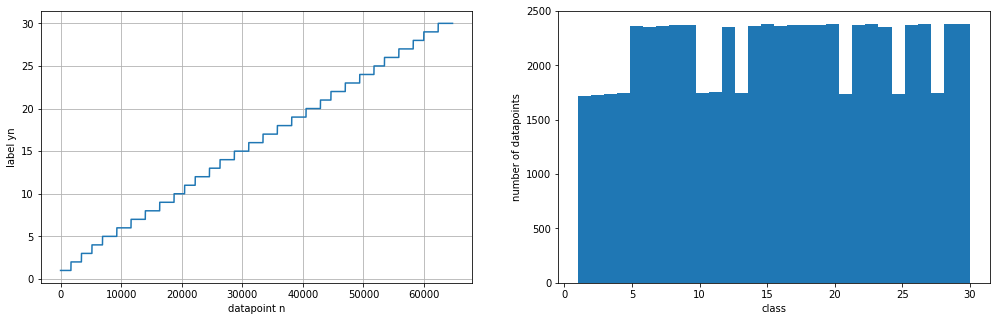

In [92]:
# Build Label vector
# Define class name vector, the index will correspond to the class label
class_names = features_og['info']['word'].unique()
y = np.ones(len(features_og))
for i in range(0,len(class_names)):
    y +=(features_og['info','word'] == class_names[i]) * i
    
# Plot the label vector
print('We have {} datapoints over the entire dataset.'.format(len(y)))
fix, axes = plt.subplots(1, 2, figsize=(17, 5))
axes[0].plot(y)
axes[0].grid()
axes[0].set_xlabel('datapoint n')
axes[0].set_ylabel('label yn')


# Plot distribution of classe
axes[1].hist(y,30)
axes[1].set_xlabel('class')
axes[1].set_ylabel('number of datapoints')

**Remark**: The classes are not perfectly balanced between classes since $64'720/30 = 2157.33$. However, the set is almost balanced between the 30 classes as we can see in the plot above, which is good enough for our application. In a next step, we split the dataset into a training set $S_t$ of size $N=4800$ and a validation set, as described above. We specify how many datapoints per class are sampled at random to build the training and the validation set respectively. We choose 160 samples for the training set ($30*160 = 4800$) and 1997 samples for the validation set ($1997*30 = 59910$). The remaining 10 words are being discarded.

In [28]:
160+1997

2157

In [51]:
for i in range(31):
    print(np.sum(y==i))

0
1713
1730
1733
1746
2359
2352
2357
2372
2372
1742
1750
2353
1746
2364
2375
2357
2367
2370
2367
2377
1734
2369
2380
2356
1733
2373
2375
1745
2377
2376


In [25]:
# Specify the number of datapoints that should be sampled in each class to build training and validation set
train_size = 160
valid_size = 1997

train_x = np.array([])
train_y = np.array([])

valid_x = np.array([])
valid_y = np.array([])

for i in range(len(class_names)):
    class_index = np.where(label_vec == (i+1))[0]
    random_index = np.random.choice(range(len(class_index)), size=train_size+valid_size, replace=False)
    
    train_x_class = class_index[random_index[:train_size]]
    train_y_class = y[train_x_class]
    train_x = np.append(train_x, train_x_class).astype(int)
    train_y = np.append(train_y, train_y_class).astype(int)

    valid_x_class = class_index[random_index[train_size:train_size+valid_size]]
    valid_y_class = y[valid_x_class]
    valid_x = np.append(valid_x, valid_x_class).astype(int)
    valid_y = np.append(valid_y, valid_y_class).astype(int)

ValueError: Cannot take a larger sample than population when 'replace=False'

## Method Validation (Kiran)

Describe that we tweaked parameters and which were found to be the optimal ones, comment on it...<br>
Show the resulting accuracy that resulted when going trough the entire training set. For this, simply load a pickle or numpy array, with the results in it and comment on it<br>
Add a .py funtion with which we could theoretically call to recompute the accuracy of the entire training set (in a "if recompute is true" conditioning). Add the function into main_pipeline.py. <br>
(Optional) Also add clustering approach to compare, otherwise we will just mention it...

In [4]:
4800/30

160.0